In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
from functools import *
import numpy as np
import json

if not os.path.exists(os.path.join(os.getcwd(), 'config.json')):
  # preventing to go always to the parent folder everytime we run the jupyter notebook without restarting
  os.chdir("..")
if not os.getcwd() in sys.path:
  sys.path.append(os.getcwd())

from analysis.analysis_commons import * 

config = None
with open('config.json') as config_file:
  config = json.load(config_file)

In [4]:
# ---------------------------------------------------
config["database"]["database"] = "wikilite" # WIKILITE
# ---------------------------------------------------

topic = 'Bayesian Statistics vs Frequentist Statistics'
topic = 'Declarative Language vs Procedural Language'
topic = 'Optimism vs Pessimism'
topic = 'Social Democracy vs Liberal Democracy'

with open('data/datavoids_per_topic_filtered.json', 'r') as f:
  datavoids_per_topic = json.load(f)
  check_repeated_keys(datavoids_per_topic)

  print("Mitigator:", datavoids_per_topic[topic]['mitigator'])
  print("Disinformer:", datavoids_per_topic[topic]['disinformer'])

  mitigator_id = int(datavoids_per_topic[topic]['mitigator_id'])
  disinformer_id = int(datavoids_per_topic[topic]['disinformer_id'])
  mitigator_label = label_for_topic(datavoids_per_topic[topic]['mitigator'])
  print("Mitigator Label:", mitigator_label)
  disinformer_label = label_for_topic(datavoids_per_topic[topic]['disinformer'])
  print("Disinformer Label:", disinformer_label)
  datavoids = datavoids_per_topic[topic]['datavoids']

config = clone_config_with_target(config, mitigator_label, disinformer_label, mitigator_id, disinformer_id)
config['datavoids'] = [ datavoids ]
print("Datavoids:", config['datavoids'])

prepare_db(config)

Mitigator: Social Democracy
Disinformer: Liberal Democracy
Mitigator Label: soc
Disinformer Label: lib
Datavoids: [['centrist', 'plurality', 'coalitions', 'reformist', 'marxism', 'populist', 'liberalism', 'ideologies', 'fascism']]
Connecting to:  wikidump
Labeling started
Labeling soc / lib
 Target nodes: 18247265 9282116
Groups count:
  soc: 2876
  lib: 698
  soc|lib: 107
Groups count:
  soc: 2180
  lib: 458
  soc|lib: 75
Assigning multilabeled to underrepresented
Groups count:
  soc: 2180
  lib: 533
Done
Connecting to:  wikidump
Creating important pages
Important pages: 2713
Dumping important pages
Dumping idf table
Creating important edges
Important edges: 21400
Dumping important edges
Connecting to lite DB
Connecting to:  wikilite
Dropping old tables
Importing important pages and edges
Importing idf
Deleting edges and nodes tables, emptying rank
Creating nodes
Creating edges
Counting
Nodes: 68064
Edges: 21686
Done
Connecting to:  wikilite
Labeling started
Labeling soc / lib
 Target

In [9]:
from labeler.database_labeler import label_database
label_database(config, filter_by_topk_words=1)

Connecting to:  wikilite
Labeling started
Labeling soc / lib
 Target nodes: 18247265 9282116
Groups count:
  soc: 2181
  lib: 458
  soc|lib: 75
Groups count:
  soc: 1824
  lib: 422
  soc|lib: 71
Assigning multilabeled to underrepresented
Groups count:
  soc: 1824
  lib: 493
Done


In [296]:
from graph import Graph
from analysis.analysis_commons import *
from rank import Rank
from strategies import *
from analysis.analysis_commons import create_simulation_name

print("Initializing ", config["database"]["database"], "graph...")

graph = Graph(config)
graph.connect()

#strategies
def misinformer_attack_on_datavoid(agent):
  config = agent.config
  _, v = results_analysis(graph, config)
  return v[config['disinformer_keyword']] > 0.15
  
# mitigator_strategy = NeighborhoodExpansionStrategy(config["datavoids"][0], config["target_node"][mitigator_label])
# mitigator_strategy = RandomStrategy(config["datavoids"][0])
mitigator_strategy = GreedyStrategy(config["datavoids"][0])

disinformer_strategy = RandomStrategy(config["datavoids"][0])
# disinformer_strategy = NeighborhoodExpansionStrategy(config["datavoids"][0], config["target_node"][disinformer_label])
# disinformer_strategy = GreedyStrategy(config["datavoids"][0])

simulation_label = mitigator_strategy.get_strategy_name() + '-' + disinformer_strategy.get_strategy_name() + '-ev'
baseline_simulation_label = 'rnd-rnd'
config["output_filename"] = 'results/' + create_simulation_name(config, simulation_label)
print('Output:', config["output_filename"])
initialize_output(config)

run_no = 0
number_of_runs = 1
while run_no < number_of_runs:
  print("Run no: " + str(run_no))
  ranking_algorithm = Rank(graph, "searchrank")
  compare_strategies(run_no, mitigator_strategy, disinformer_strategy, ranking_algorithm, graph, config)
  run_no += 1

graph.close()
close_output(config)
print("Done")

Initializing  wikilite graph...
Connecting to:  wikilite
Output: results/wikilite-opt_pes-top10-norank-greedy-rnd-ev.csv
Run no: 0
    Setting all nodes and edges to active...
  Testing strategy: 
             RandomStrategy
             GreedyStrategy
    Disinformer initializing plan...
    Mitigator initializing plan...
Running....
..............................
..............................
..............................
..............................
..............................
.....

Disinformer done after 156 steps
Mitigator done after 156 steps


Done


In [297]:
# Get output

from analysis.analysis_commons import readable_group_name, readable_strategies_names_with_labels, get_output

steps_per_strategy, strategies, id_max_rank = get_output(config)
print("Strategies: ", strategies)

Strategies:  ['GreedyStrategy|RandomStrategy']


enumerate(config[datavoids]) [(0, ['nihilism', 'affective', 'pessimism', 'depressive', 'adolescents', 'innate', 'pessimistic', 'coping', 'psychologists', 'optimism', 'metaphysical', 'perceive'])]


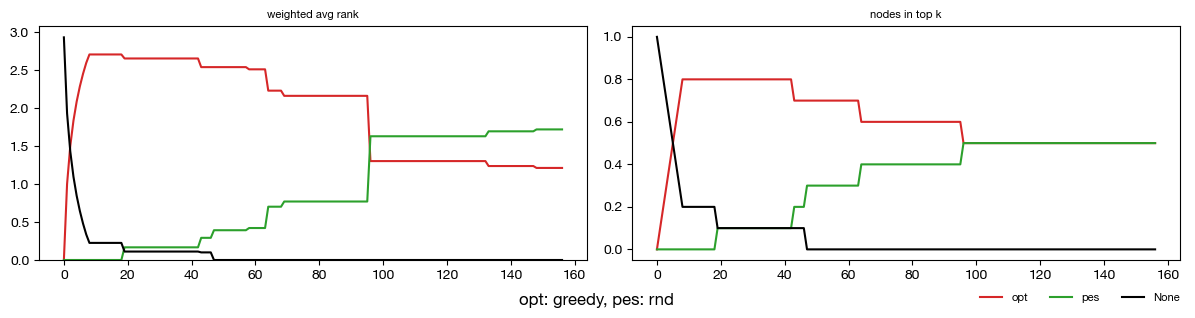

In [298]:
# Plot results

import matplotlib.pyplot as plt
plt.rc('font', family='Helvetica Neue')
# plt.rcParams['figure.dpi'] = 300
plt.rcParams['image.cmap'] = 'tab10'

fig, axs = plt.subplots(len(config["datavoids"]), 2, squeeze=False)
# fig.suptitle('Filtering for nodes that contain a specific data void term in the content')

strategy = strategies[0]

print("enumerate(config[datavoids])", list(enumerate(config["datavoids"])))
for datavoid_no, datavoid in enumerate(config["datavoids"]):
  if isinstance(datavoid, list):
    datavoid = "|".join(datavoid)
  axs_row = axs[datavoid_no]

  xvals = []
  yvals = { v: {gr: [] for gr in config["target_groups"]} for v in ["weighted_avg_rank", "nodes_in_top_k"] }
  for step_no in sorted(datavoids_steps_per_strategy[strategy].keys()):
    xvals.append(step_no)
    for g in config["target_groups"]:
      for v in ["weighted_avg_rank", "nodes_in_top_k"]:
        vals = datavoids_steps_per_strategy[strategy][step_no][datavoid][g][v]
        y_val = sum(vals) / len(vals)
        yvals[v][g].append(y_val)
      
  for g in config["target_groups"]:
    axs_row[0].plot(
        xvals,
        yvals["weighted_avg_rank"][g],
        label=readable_group_name(g),
        color=config["groups_colors"][g])
    axs_row[0].set_title(f'weighted avg rank', fontsize=8)
    axs_row[0].autoscale(enable=True, axis='y')
    axs_row[0].set_ylim(bottom=0)

    axs_row[1].plot(
        xvals,
        yvals["nodes_in_top_k"][g],
        label=readable_group_name(g),
        color=config["groups_colors"][g])
    axs_row[1].set_title(f'nodes in top k', fontsize=8)
    axs_row[0].autoscale(enable=True, axis='y')
    axs_row[0].set_ylim(bottom=0)

fig.set_size_inches(12, max(3, len(config["datavoids"])))
plt.tight_layout(pad=1)
handles, labels = axs_row[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='lower right', borderaxespad=1, fontsize=8, ncol=len(labels))
legend.get_frame().set_linewidth(0.0)
fig.suptitle(f'{readable_strategies_names_with_labels(strategy, config)}', fontsize=12, y=0.01)
plt.subplots_adjust(bottom=0.12)

plt.show()

diff weighted_avg_rank opt 146.88531746031734
diff weighted_avg_rank pes -91.87857142857146
diff weighted_avg_rank None -55.00674603174605
diff nodes_in_top_k opt 30.20000000000006
diff nodes_in_top_k pes -6.399999999999992
diff nodes_in_top_k None -23.800000000000015


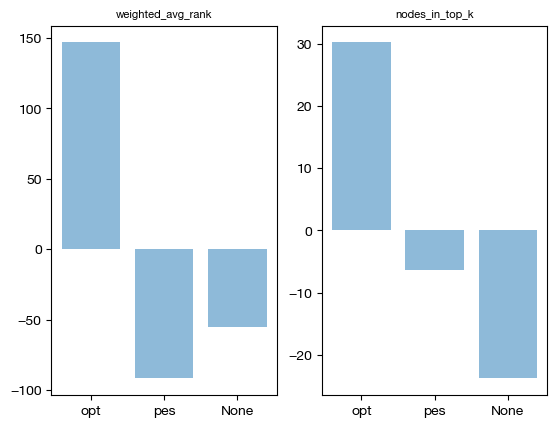

In [299]:
baseline_config = config.copy()
baseline_config["output_filename"] = 'results/' + create_simulation_name(baseline_config, baseline_simulation_label)
steps_per_strategy_baseline, strategies_baseline, id_max_rank_baseline = get_output(baseline_config)
strategy_baseline = strategies_baseline[0]

for datavoid_no, datavoid in enumerate(config["datavoids"]):
  if isinstance(datavoid, list):
    datavoid = "|".join(datavoid)
  axs_row = axs[datavoid_no]

  x_vals = []
  for step_no in sorted(datavoids_steps_per_strategy_baseline[strategy_baseline].keys()):
    x_vals.append(step_no)

  y_vals = { 
    v: {gr: [{} for _ in x_vals] for gr in config["target_groups"]} 
    for v in ["weighted_avg_rank", "nodes_in_top_k"] 
  }


  for step_no in sorted(datavoids_steps_per_strategy_baseline[strategy_baseline].keys()):
    for g in config["target_groups"]:
      for v in ["weighted_avg_rank", "nodes_in_top_k"]:
        vals = datavoids_steps_per_strategy_baseline[strategy_baseline][step_no][datavoid][g][v]
        y_val_baseline = sum(vals) / len(vals)
        y_vals[v][g][step_no][baseline_simulation_label] = y_val_baseline

        vals = datavoids_steps_per_strategy[strategy][step_no][datavoid][g][v]
        y_val = sum(vals) / len(vals)
        y_vals[v][g][step_no][simulation_label] = y_val

  diff_values = {v: [] for v in ["weighted_avg_rank", "nodes_in_top_k"]}
  for v in ["weighted_avg_rank", "nodes_in_top_k"]:
    for g in config["target_groups"]:
      diff = reduce(lambda acc, y: acc + (y[simulation_label] - y[baseline_simulation_label]), y_vals[v][g], 0)
      print("diff", v, g, diff)
      diff_values[v].append({'g':g, 'diff': diff})

  # plot of these differences with matplotlib
  fig, axs = plt.subplots(1, 2, squeeze=False)
  for vidx, v in enumerate(["weighted_avg_rank", "nodes_in_top_k"]):
    labels = [d['g'] for d in diff_values[v]] 
    values = [d['diff'] for d in diff_values[v]]
    axs[0][vidx].bar(labels, values, alpha=0.5)
    axs[0][vidx].set_title(v, fontsize=8)
  plt.show()


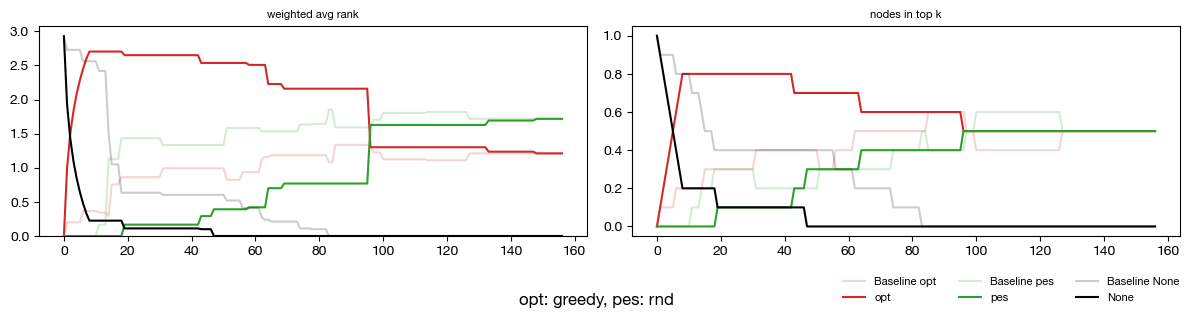

In [300]:
# Evaluating the differences between simulations 
fig, axs = plt.subplots(len(config["datavoids"]), 2, squeeze=False)

for datavoid_no, datavoid in enumerate(config["datavoids"]):
  if isinstance(datavoid, list):
    datavoid = "|".join(datavoid)
  axs_row = axs[datavoid_no]

  for g in config["target_groups"]:
    axs_row[0].plot(
      x_vals,
      list([y_vals["weighted_avg_rank"][g][step_no][baseline_simulation_label] for step_no in x_vals]),
      label=f'Baseline {readable_group_name(g)}',
      color=config["groups_colors"][g],
      alpha=0.2)
    axs_row[0].set_title(f'weighted avg rank', fontsize=8)
    axs_row[0].autoscale(enable=True, axis='y')

    axs_row[1].plot(
      x_vals,
      [y_vals["nodes_in_top_k"][g][step_no][baseline_simulation_label] for step_no in x_vals],
      label=f'Baseline {readable_group_name(g)}',
      color=config["groups_colors"][g],
      alpha=0.2)
    axs_row[1].set_title(f'nodes in top k', fontsize=8)
    axs_row[1].autoscale(enable=True, axis='y')

    axs_row[0].plot(
      x_vals,
      [y_vals["weighted_avg_rank"][g][step_no][simulation_label] for step_no in x_vals],
      label=f'{readable_group_name(g)}',
      color=config["groups_colors"][g])
    axs_row[0].set_title(f'weighted avg rank', fontsize=8)
    axs_row[0].autoscale(enable=True, axis='y')
    axs_row[0].set_ylim(bottom=0)

    axs_row[1].plot(
        x_vals,
        [y_vals["nodes_in_top_k"][g][step_no][simulation_label] for step_no in x_vals],
        label=f'{readable_group_name(g)}',
        color=config["groups_colors"][g])
    axs_row[1].set_title(f'nodes in top k', fontsize=8)
    axs_row[1].autoscale(enable=True, axis='y')


fig.set_size_inches(12, max(3, len(config["datavoids"])))
plt.tight_layout(pad=1)
handles, labels = axs_row[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='lower right', borderaxespad=1, fontsize=8, ncol=int(len(labels)/2))
legend.get_frame().set_linewidth(0.0)
fig.suptitle(f'{readable_strategies_names_with_labels(strategy, config)}', fontsize=12, y=0.01)
plt.subplots_adjust(bottom=0.2)


plt.show()


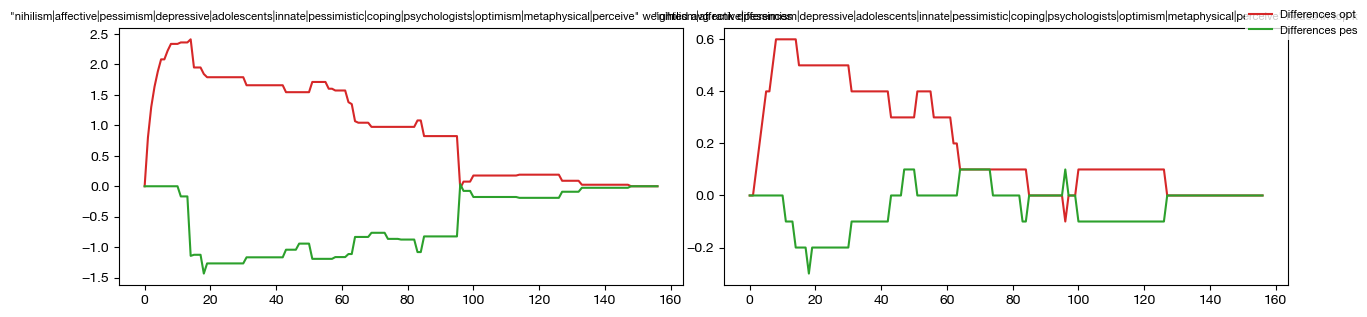

In [301]:
# Evaluating the differences between simulations 
fig, axs = plt.subplots(len(config["datavoids"]), 2, squeeze=False)

for datavoid_no, datavoid in enumerate(config["datavoids"]):
  if isinstance(datavoid, list):
    datavoid = "|".join(datavoid)
  axs_row = axs[datavoid_no]

  for g in filter(lambda g: g != "None", config["target_groups"]):
    differences = [
      (y_vals["weighted_avg_rank"][g][step_no][simulation_label] - 
       y_vals["weighted_avg_rank"][g][step_no][baseline_simulation_label]
      ) for step_no in x_vals
    ]
    axs_row[0].plot(
      x_vals,
      differences,
      label=f'Differences {readable_group_name(g)}',
      color=config["groups_colors"][g])
    axs_row[0].set_title(f'"{datavoid}" weighted avg rank differences', fontsize=8)
    axs_row[0].autoscale(enable=True, axis='y')

    differences = [
      (y_vals["nodes_in_top_k"][g][step_no][simulation_label] - 
       y_vals["nodes_in_top_k"][g][step_no][baseline_simulation_label]
      ) for step_no in x_vals
    ]
    axs_row[1].plot(
      x_vals,
      differences,
      label=f'Differences {readable_group_name(g)}',
      color=config["groups_colors"][g])
    axs_row[1].set_title(f'"{datavoid}" nodes in top k', fontsize=8)
    axs_row[1].autoscale(enable=True, axis='y')

fig.set_size_inches(12, max(3, len(config["datavoids"])))
plt.tight_layout(pad=0.1)
handles, labels = axs_row[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper right', borderaxespad=0.5, fontsize=8)
legend.get_frame().set_linewidth(0.0)

plt.show()
